<a href="https://colab.research.google.com/github/JunLee1422/CBNU_2023254019_/blob/main/apprentice%20project/apprentice_project_honey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving 미국꿀.xlsx to 미국꿀 (18).xlsx
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Number               1115 non-null   int64  
 1   state                1115 non-null   object 
 2   colonies_number      1115 non-null   int64  
 3   yield_per_colony     1115 non-null   int64  
 4   production           1115 non-null   int64  
 5   stocks               1115 non-null   int64  
 6   average_price        1115 non-null   float64
 7   value_of_production  1115 non-null   int64  
 8   year                 1115 non-null   int64  
dtypes: float64(1), int64(7), object(1)
memory usage: 78.5+ KB


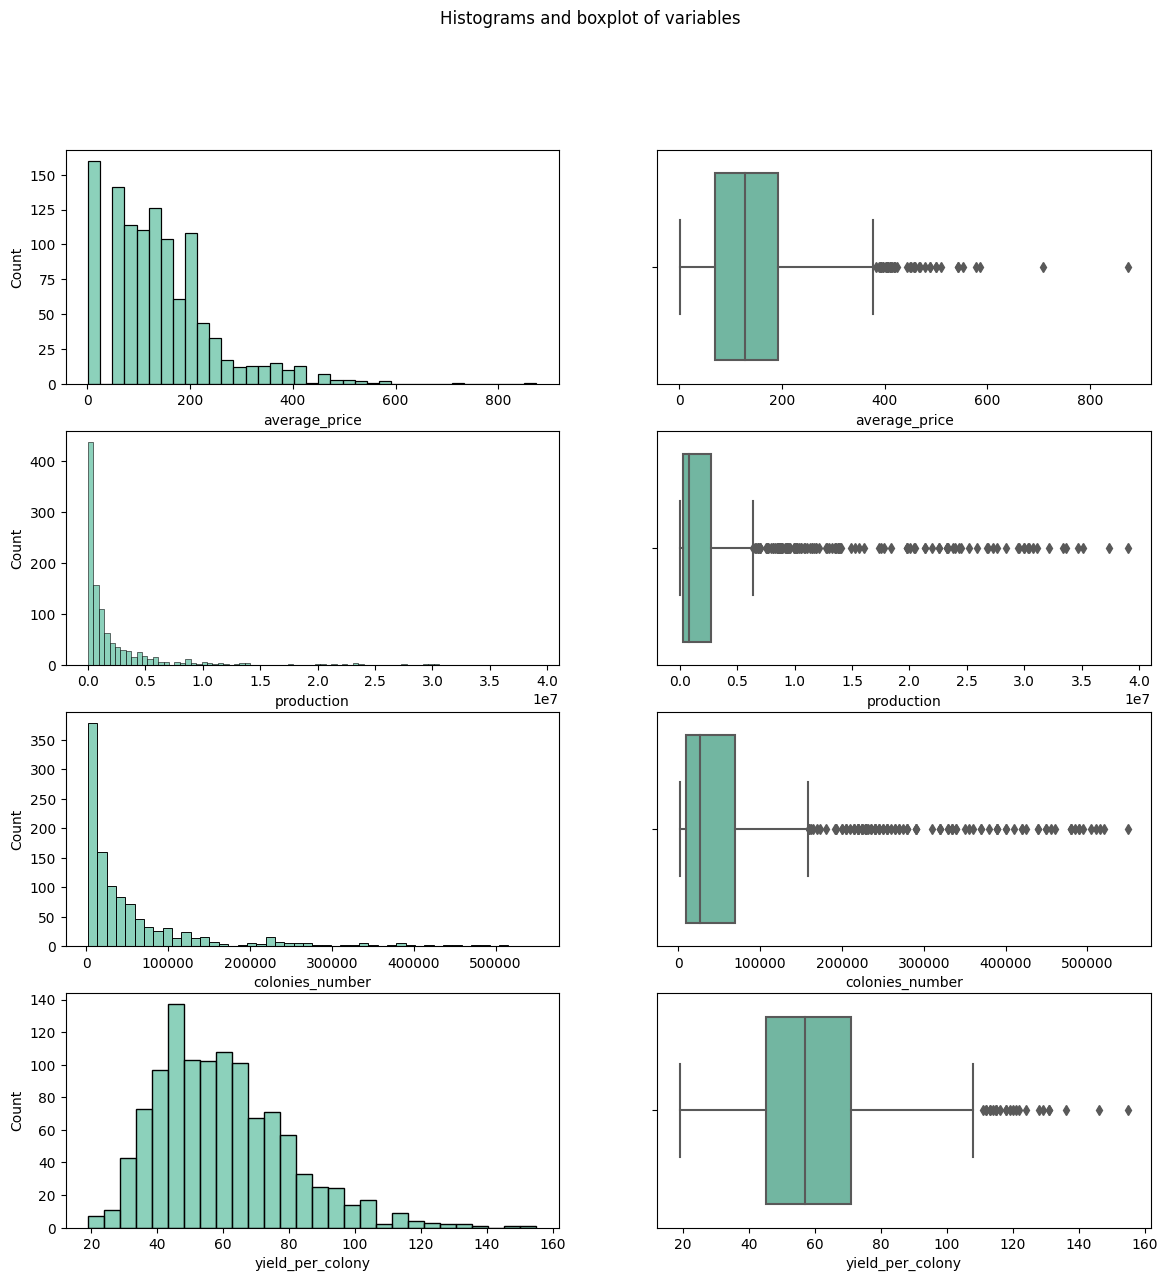

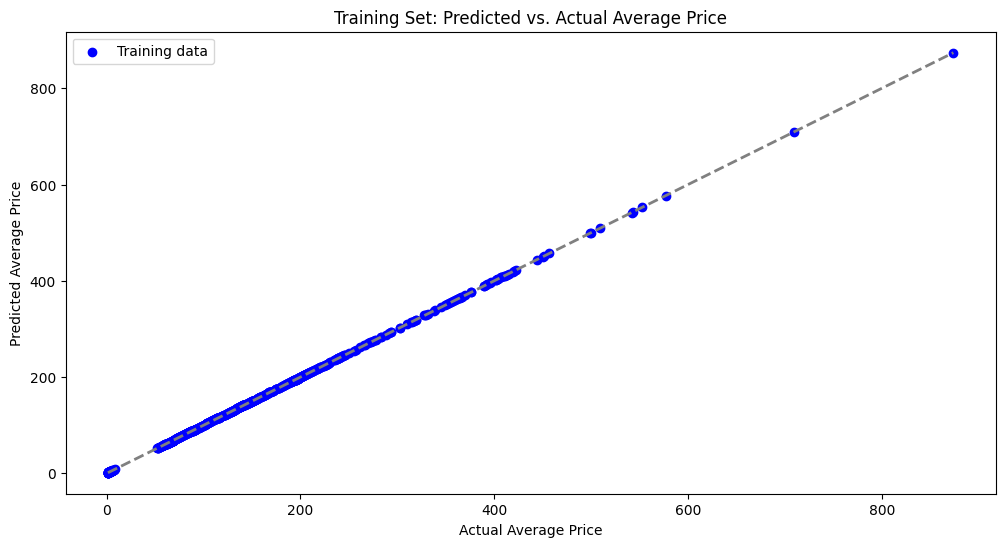

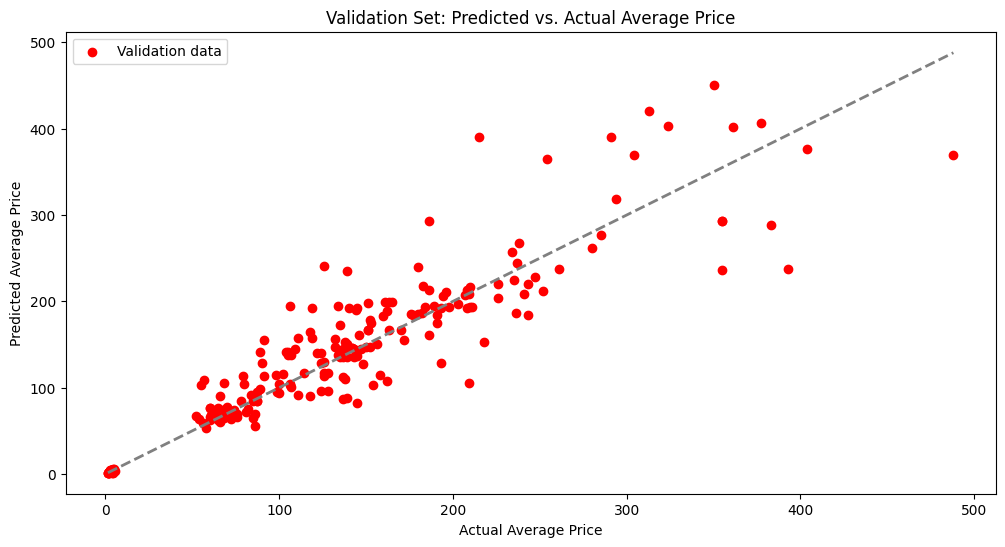

MAE: 23.326502242152465
MAPE: 0.17557661757698922
MSE: 1602.6758551569508
RMSE: 40.03343421637658
Max Error: 253.0
r2 score: 0.8516897685154027
Predicted Average Price: 2.77
Predicted Average Price: 2.77


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
import ipywidgets as widgets
from IPython.display import display
from google.colab import files
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, max_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
import time

sns.set_palette(palette='Set2')

# 파일 업로드
uploaded = files.upload()

# 업로드한 파일 이름 입력
file_name = '미국꿀.xlsx'

# 데이터 불러오기
df = pd.read_excel(file_name)

df.info()
df.isnull().sum()
df.describe()

# 시각화: Histograms and Boxplots
fig, axes = plt.subplots(4, 2, figsize=(14, 14))
plt.suptitle('Histograms and boxplot of variables')

sns.histplot(ax=axes[0, 0], x=df['average_price'], data=df)
sns.boxplot(ax=axes[0, 1], x=df['average_price'], data=df)

sns.histplot(ax=axes[1, 0], x=df['production'], data=df)
sns.boxplot(ax=axes[1, 1], x=df['production'], data=df)

sns.histplot(ax=axes[2, 0], x=df['colonies_number'], data=df)
sns.boxplot(ax=axes[2, 1], x=df['colonies_number'], data=df)

sns.histplot(ax=axes[3, 0], x=df['yield_per_colony'], data=df)
sns.boxplot(ax=axes[3, 1], x=df['yield_per_colony'], data=df)

plt.show()

# 데이터 분할
X = df[['state', 'colonies_number', 'yield_per_colony', 'year', 'stocks']]
y = df['average_price']

# average_price를 예측하도록 변경
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=333)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=333)

# Custom Transformer 정의
class HoneyProductionTransformerNum(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # 이상치 확인을 위한 변수 계산
        self.colonies_number_p95 = X['colonies_number'].quantile(0.95)
        self.colonies_number_p05 = X['colonies_number'].quantile(0.05)
        self.colonies_number_mean = X['colonies_number'].mean()
        self.yield_per_colony_p95 = X['yield_per_colony'].quantile(0.95)
        self.yield_per_colony_p05 = X['yield_per_colony'].quantile(0.05)
        self.yield_per_colony_mean = X['yield_per_colony'].mean()
        return self

    def transform(self, X, y=None):
        # 이상치 처리
        X.loc[(X['colonies_number'] > self.colonies_number_p95) | (X['colonies_number'] < self.colonies_number_p05), 'colonies_number'] = self.colonies_number_mean
        X.loc[(X['yield_per_colony'] > self.yield_per_colony_p95) | (X['yield_per_colony'] < self.yield_per_colony_p05), 'yield_per_colony'] = self.yield_per_colony_mean
        return X

# 파이프라인 정의
numeric_features = ['colonies_number', 'yield_per_colony', 'year', 'stocks']
categorical_features = ['state']

numeric_transformer = Pipeline(steps=[
    ('outlier', HoneyProductionTransformerNum()),
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehotenc', OneHotEncoder(handle_unknown='ignore'))  # handle_unknown 추가
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ]
)

regressors = [
    DummyRegressor(strategy="mean"),
    LinearRegression(),
    DecisionTreeRegressor()
]

scalers = [StandardScaler(), MinMaxScaler()]

models_df = pd.DataFrame()

for model in regressors:
    for scaler in scalers:
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipe_params = {
            'preprocessor__numerical__scaler': scaler,
            'model': model
        }

        pipe.set_params(**pipe_params)

        start_time = time.time()
        pipe.fit(X_train, y_train)
        end_time = time.time()

        y_pred_train = pipe.predict(X_train)
        y_pred_val = pipe.predict(X_val)

        r2_train = r2_score(y_train, y_pred_train)
        r2_val = r2_score(y_val, y_pred_val)

        mae_train = mean_absolute_error(y_train, y_pred_train)
        mae_val = mean_absolute_error(y_val, y_pred_val)

        mape_train = mean_absolute_percentage_error(y_train, y_pred_train)
        mape_val = mean_absolute_percentage_error(y_val, y_pred_val)

        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_val = mean_squared_error(y_val, y_pred_val)

        rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
        rmse_val = mean_squared_error(y_val, y_pred_val, squared=False)

        max_error_train = max_error(y_train, y_pred_train)
        max_error_val = max_error(y_val, y_pred_val)

        param_dict = {
            'model': model.__class__.__name__,
            'scaler': scaler.__class__.__name__,
            'r2_train': r2_train,
            'r2_val': r2_val,
            'mae_train': mae_train,
            'mae_val': mae_val,
            'mape_train': mape_train,
            'mape_val': mape_val,
            'mse_train': mse_train,
            'mse_val': mse_val,
            'rmse_train': rmse_train,
            'rmse_val': rmse_val,
            'max_error_train': max_error_train,
            'max_error_val': max_error_val,
            'time': end_time - start_time
        }

        models_df = pd.concat([models_df, pd.DataFrame(param_dict, index=[0])], ignore_index=True)

models_df.sort_values('rmse_val', inplace=True)
models_df.reset_index(drop=True, inplace=True)

# 최적 모델 선택 및 훈련 데이터 적용
pipe_params = {
    'preprocessor__numerical__scaler': StandardScaler(),
    'model': DecisionTreeRegressor()  # 모델 선택
}

pipe.set_params(**pipe_params)
pipe.fit(X_train, y_train)

# 훈련 및 검증 세트에서의 예측값
y_pred_train = pipe.predict(X_train)
y_pred_val = pipe.predict(X_val)

# 훈련 세트 예측값 vs. 실제값
plt.figure(figsize=(12, 6))
plt.scatter(y_train, y_pred_train, color='blue', label='Training data')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], linestyle='--', color='gray', linewidth=2)
plt.title('Training Set: Predicted vs. Actual Average Price')
plt.xlabel('Actual Average Price')
plt.ylabel('Predicted Average Price')
plt.legend()
plt.show()

# 검증 세트 예측값 vs. 실제값
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_pred_val, color='red', label='Validation data')
plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], linestyle='--', color='gray', linewidth=2)
plt.title('Validation Set: Predicted vs. Actual Average Price')
plt.xlabel('Actual Average Price')
plt.ylabel('Predicted Average Price')
plt.legend()
plt.show()
y_pred_test = pipe.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test)
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)
max_error_test = max_error(y_test, y_pred_test)
r2_score_test = r2_score(y_test, y_pred_test)

print('MAE:', mae_test)
print('MAPE:', mape_test)
print('MSE:', mse_test)
print('RMSE:', rmse_test)
print('Max Error:', max_error_test)
print('r2 score:', r2_score_test)

# 입력값으로 average_price 예측
input_data = pd.DataFrame({
    'state': ['example_state'],
    'colonies_number': [40000],
    'yield_per_colony': [280000],
    'year': [2022],  # 예시로 임의의 년도 지정
    'stocks': [1000]  # 예시로 임의의 stocks 값 지정
})

# 예측
predicted_average_price = pipe.predict(input_data)
print('Predicted Average Price:', predicted_average_price[0])
print('Predicted Average Price:', predicted_average_price[0])